# Conformal Predictions for ML Models (Dupont)

This is a notebook dedicated to the python implementation of the conformal prediction framework for ml models.

**Index**
* [Library Imports](#library_imports)
* [Enviroments & Models Function](#environment_models) 
* [Data Split Function](#data_split)
* [NonConformist Class](#nonconformal_class)
* [Loading Model and Environments](#Loading_Model)
* [Data Setup](#data_setup)
* [Training and Calibration Procedure](#training_calibration)
* [Efficiency and Validity](#efficiency_validity)


<a id='library_imports'></a>
## Library Imports

Import necessary modules for notebook

In [1]:
import dotenv
import prolerep.analysis.utils as utils
import mlflow.pyfunc
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import sys
import time

import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

<a id='environment_models'></a>
## Load Environment and Models Function
* Function comitted to preparing the environment variables and model to be used

In [2]:
def model_prep(env):
    dotenv.load_dotenv(env)
    runs = mlflow.search_runs(4) #ExperimentID:(4:Expression,13:Activity,14:Stability)
    cols = ["run_id", "params.model_name", "metrics.valid_r_square",
        "metrics.train_r_square", "params.prepared_dataset_uri"]
    best = (
    runs
    .sort_values("metrics.valid_r_square", ascending=False)
    .groupby("params.model_name")
    .head(n=1)
    [cols]
    .set_index("params.model_name"))    
    model = mlflow.pyfunc.load_model(f"runs:/{best.loc['PLSRun'].run_id}/logged_model")
    print("Environment and Models have been loaded")
    return model

<a id='data_split'></a>
## Data Split Function
* Function dedicated to splitting original dataset

In [3]:
def data_split(df):
    train = df.loc[df['split'] == 'train']
    valid = df.loc[df['split'] == 'valid']
    X_test = valid.iloc[:,:-1]
    y_test = valid.iloc[:,-1] 
    X_train = train.iloc[:,:-1] 
    y_train = train.iloc[:,-1] 
    X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size =0.2)
    print("Data has been split")
    print("X_train and y_train shape: "+ str(X_train.shape) + str(y_train.shape))
    print("X_cal and y_cal shape: "+ str(X_cal.shape) + str(y_cal.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   X_train.shape[1],
                                                   np.unique(y_train).size))
    return X_test, y_test, X_train, y_train, X_cal, y_cal


<a id='nonconformal_class'></a>
## NonConformist Class

In [4]:
class NonConformist():
    
    def __init__(self, model):
        self.model = model
    
    def underlying_fit (self, X_train, y_train):
        '''
        Train underlying model on proper training data
            
        @Params
        X_train: has shape (n_train, n_features)
        y_train: has shape (n_train)
        
        -------
        Returns:
        
        A fitted model
        '''
        
        self.model.fit(X_train,y_train)
        
        print("Model has been fitted")
        
    def calibration_predict(self, X_cal):
        '''
            Obtain predictions from the underlying model using X_cal data. 
            Returns an output of predicted real values as numpy.array of shape (n_test)
            
        @params
        X_cal: numpy array has shape (n_train, n_features)
        
        --------
        Returns:
        
        Predictions: Set of predictions based from the calibration data
        '''
        calibration_predictions = self.model.predict(X_cal)

        print("Calibration Predictions Established")
        return calibration_predictions
                     
    def apply_nonconformity(self, calibration_predictions, y_cal):
        '''
        Calculates absolute error nonconformity scores for calibration set.
        For each correct output in ``y``, nonconformity is defined as
        math::
        | y_i (predicted labels) - y^_i (true labels) |     
       
        @params
        true_labels is a numpy array of (true) labels 
        predictions is a numpy array of predicted labels
        
        Returns:
        Calibration scores: numpy array of shape [n_samples]
        Non conformity scores of the samples
        '''
               
        true_labels = np.array(y_cal)
        calibration_predictions = calibration_predictions.flatten()
        
        conformity_scores = np.abs(calibration_predictions - true_labels)
        conformity_scores = np.sort(conformity_scores)[::-1] #sort in descending order
        print("Calibration Conformal Scores Obtained")
        
        return conformity_scores
    
    def apply_inverse(self, conformity_scores, significance):
        ''' 
        Function applies the partial inverse of the nonconformity function
        to calculate the prediction intervals where:
               
        @params
        calibration_scores: Nonconformity scores obtained from the conformal predictor [n_calibration_samples]
        Significance: Float value between 0-1 (i.e. 0.05)
        
        Returns:
        
        Interval: Numpy array of shape [n_samples, 2] that determines
        the min and max interval boundaries for each prediction
        '''
        
        border = int(np.floor(significance * (conformity_scores.size + 1))) - 1
        border = min(max(border, 0), conformity_scores.size - 1)
        
        return np.vstack([conformity_scores[border], conformity_scores[border]])
    
    def test_predict(self, X_test):
        '''
            Obtain predictions from the underlying model using X_test data. 
            Returns an output of predicted real values as numpy.array of shape (n_test)
            
        @params
        X_test: numpy array has shape (n_train, n_features)
        
        Returns:
        
        Predictions: Set of predictions based from the test data
        '''
        test_predictions = self.model.predict(X_test)

        print("Test Predictions Established")
        
        return test_predictions

    def conformal_predictions(self, X_test, conformity_scores, significance):
        """
        Function will construct the prediction intervals 
        for a set of test examples. 
        
        This applies the partial inverse nonconformity function
        to each prediction from the underlying model, thus
        resulting in a prediction interval for each test pattern.

        @params
        ----------
        X_test: Numpy array of shape [n_samples, n_features]
        Inputs of test patterns for which to predict final output values

        Significance: Considered a float between 0 and 1; determimned as 
        the maximum allowed error rate of predictions.
        
        Returns
        -------
        p : numpy array of shape [n_samples, 2] or [n_samples, 2, 99]
        When significance value is a float between 0 and 1, then p 
        contains the prediction intervals (minimum and maximum boundaries)
        for the set of test patterns at the chosen significance level.
        """
        n_test = X_test.shape[0] #Takes shape of X_test row number
        norm = np.ones(n_test) #Returns an array of X_test shape, filled with ones.
        test_predictions = self.test_predict(X_test) #Predictions from test data
        test_predictions = test_predictions.flatten() #Returns a collapsed array as 1D

        if significance:
            intervals = np.zeros((X_test.shape[0], 2)) #Creates empty 2D numpy array for saving prediction intervals
            err_dist = self.apply_inverse(conformity_scores, significance) #Applies inverse of nonconformity scores
            err_dist = np.hstack([err_dist] * n_test) ##Stack arrays in sequence horizontally (column wise)
            err_dist *= norm

            intervals[:, 0] = test_predictions - err_dist[0, :] #[0] creates lower boundary of the prediction interval
            intervals[:, 1] = test_predictions + err_dist[1, :] #[1] creates upper boundary of the prediction interval
        
            print("Prediction Intervals Created")

            return intervals
        


<a id='Evaluation_Class'></a>
## Evaluation Class

In [5]:
class Evaluation():
    
    def __init__(self):
        pass
    
    #########################
    ## Efficiency Measures ##
    #########################
    def prediction_size(self, predictions):
        """
        Calculates the general and average prediction interval size 
        based on a conformal prediction regression model.
        
        @params
        prediction_intervals: Prediction Intervals determined from the test patterns
        
        returns:
        
        Interval Size: Array that contains the size of the predicted intervals
        """
        interval_size = predictions[:, 1] - predictions[:, 0] #Efficiency measure
        mean_size = np.mean(interval_size)
        
        return interval_size, mean_size    
    
    def evaluation_table(self, predictions, size, y):
        '''
        Gives a final table that contains the prediction intervals, their size
        and original (true) labels of the test patterns. 
        Allows to determine efficiency of predictions
        
        @params
        predictions: Prediction intervals determined from the test patterns
        size: Size of the respective prediction intervals
        y: array of the true labels (i.e. y_test)
        
        returns:
        
        Tabulated results for the evaluation function
        ''' 
        header = ['Min','Max','Original Label','Interval Size']
        table = np.vstack([predictions.T, y, size.T]).T
        predictions_table = pd.DataFrame(table, columns = header)

        return predictions_table


    #########################
    ## Validity Measures ####
    #########################
    
    def correct_predictions(self, predictions, y_test, significance = None):
        """
        Calculates the number of correct predictions (error rate) made by
        the conformal functions in a regression model and its average error rate.
        
        @params
        predictions: Prediction intervals determined from the test patterns
        y: array of the true labels (i.e. y_test)
        significance: Float value between 0-1 (i.e. 0.05)
        """
        
        idx = int(significance * 100 - 1)
        prediction = predictions[:idx]
        
        low = y_test >= predictions[:, 0]
        high = y_test <= predictions[:, 1]
        correct = low * high
        
        predictions_rate = y_test[correct].size
        avg_error_rate = 1 - predictions_rate / y_test.size

        return predictions_rate, avg_error_rate


### Running Functions and Class Methods

#### Loading Environments and Model
<a id='Loading_Model'></a>

In [6]:
env = ".env"
model = model_prep(env) #Establish underying ML Model

Environment and Models have been loaded


/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PLSRegression from version 0.22.2.post1 when using version 0.23.1. This might lead

#### Data Setup
<a id='data_setup'></a>
* Divide training data into two subsets (proper training and calibration data)

In [7]:
df = utils.read_csv_from_s3("s3://mlflow/4/1a163dd9fecc435fbf340dbdd5170cb9/artifacts/dataset.csv") #Upload dataset from MLFlow
X_test, y_test, X_train, y_train, X_cal, y_cal = data_split(df)
df.head()

Data has been split
X_train and y_train shape: (11694, 3)(11694,)
X_cal and y_cal shape: (2924, 3)(2924,)
11694 instances, 3 features, 10554 classes


,new_host,split,sequence,expression
0,False,train,--AQVPYGVSQIKAPALH-SQGYTGQNVKVAVIDTGIDSSHEDLKV...,0.039268
1,False,train,--ASVPYGVSQIKAPALH-SQGYTGSNVKVAVIDSGIDSSHPDLKV...,0.039268
2,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.261457
3,False,train,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,0.265189
4,False,train,-AQAVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHGDLNI...,0.419681


#### Training and Calibration Procedure
* Train the underlying model
* Define Non-Conformity function, measure nonconformity of calibration examples and obtain their respective nonconformal scores
<a id='training_calibration'></a>


In [8]:
nc = NonConformist(model) #Define NonConformist Class
nc.underlying_fit(X_train, y_train) 

Model has been fitted


In [9]:
calibration_predictions = nc.calibration_predict(X_cal)
conformity_scores = nc.apply_nonconformity(calibration_predictions, y_cal)

Calibration Predictions Established
Calibration Conformal Scores Obtained


#### Prediction Procedure
<a id='prediction_procedure'></a>

* Produce prediction intervals for the test set, with a confidence of 95%

In [10]:
prediction_intervals = nc.conformal_predictions(X_test, conformity_scores, significance = 0.05)
prediction_intervals

Test Predictions Established
Prediction Intervals Created


array([[-0.02111332,  0.78736659],
       [-0.65142327,  0.15705664],
       [ 0.16757081,  0.97605072],
       ...,
       [ 0.0454509 ,  0.85393081],
       [ 0.57903583,  1.38751574],
       [ 0.50257096,  1.31105087]])

#### Efficiency and Validity
* Conformal predictors are automatically valid
* Efficiency depends on the nonconformity function (and thus the underlying model)
<a id='efficiency_validity'></a>


In [11]:
ev = Evaluation()
interval_size, mean_size = ev.prediction_size(prediction_intervals)
predictions_table = ev.evaluation_table(prediction_intervals, interval_size, y_test)
predictions_table

,Min,Max,Original Label,Interval Size
0,-0.021113,0.787367,0.039268,0.80848
1,-0.651423,0.157057,0.039268,0.80848
2,0.167571,0.976051,0.335382,0.80848
3,-0.129542,0.678938,0.144229,0.80848
4,-0.155751,0.652729,0.146150,0.80848
...,...,...,...,...
3598,0.080947,0.889427,0.422425,0.80848
3599,0.021708,0.830188,0.102519,0.80848
3600,0.045451,0.853931,0.079030,0.80848
3601,0.579036,1.387516,0.923660,0.80848


In [12]:
ev=Evaluation()
ev.correct_predictions(prediction_intervals, y_test, significance = 0.05)

/home/john/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


(3360, 0.06744379683597002)

Test Predictions Established


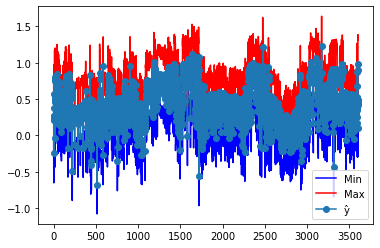

In [14]:
fig = plt.figure()
ax = plt.axes()
min_val = prediction_intervals[:, 0]
max_val = prediction_intervals[:, 1]
true_values = y_test
predicted_values = nc.test_predict(X_test) #Predictions from test data
plt.plot(min_val, label = "Min", color='blue')
plt.plot(max_val, label = "Max", color='red')
#plt.plot(true_values, label = "y", color = "black")
plt.plot(predicted_values, label = "y\u0302", marker='o')
plt.legend()
plt.show()